In [122]:
import random
import pandas as pd
import numpy as np
from utils import *
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
# df = pd.read_csv('data.csv')
df = pd.read_csv('regular.csv')

In [3]:
def calError(row):
    if row['TOTAL'] == 0:
        val = 0
    else:
        val = (row['QTYERROR'] / row['TOTAL']) * 100
    return val

df['TOTAL'] =  df[['QTYERROR', 'QTYGOOD']].sum(axis=1)
df['ERROR_RATE'] = df.apply(calError, axis=1)
df.loc[:, ('WORKER')] = df['WORKER'].astype(str)
df.loc[:, ('WrkCtrID')] = df['WrkCtrID'].astype(str)
df['TIME_DEVIATION'] = df['CalcHours'] - df['Hours']

In [4]:
df.nunique()

Unnamed: 0        931
ProdId            234
ITEMID             18
OprID              22
WORKER             14
WrkCtrID           34
CalcHours         189
Amount            186
Hours             156
QTYERROR            2
QTYGOOD            47
TIME_DEVIATION    169
anomaly             1
TOTAL              47
ERROR_RATE          5
dtype: int64

In [5]:
df['ERROR_RATE'].unique()

array([  0.        ,  14.28571429, 100.        ,  16.66666667,
         5.88235294])

In [6]:
Counter(df['ERROR_RATE'])

Counter({0.0: 927,
         14.285714285714285: 1,
         100.0: 1,
         16.666666666666664: 1,
         5.88235294117647: 1})

In [7]:
df.describe()

,Unnamed: 0,CalcHours,Amount,Hours,QTYERROR,QTYGOOD,TIME_DEVIATION,anomaly,TOTAL,ERROR_RATE
count,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.0,931.000000,931.000000
mean,560.939850,14.232153,64.232352,12.821561,0.004296,27.273899,1.410592,1.0,27.278195,0.146976
std,315.529319,54.278323,538.854719,57.691800,0.065442,172.299905,43.751456,0.0,172.299405,3.359523
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-319.680000,1.0,0.000000,0.000000
25%,294.000000,0.666666,2.315000,0.360720,0.000000,0.000000,0.076820,1.0,0.000000,0.000000
50%,579.000000,2.000000,6.670000,1.000000,0.000000,5.000000,0.666667,1.0,5.000000,0.000000
75%,828.500000,8.000000,17.355000,4.000000,0.000000,14.000000,2.000000,1.0,14.000000,0.000000
max,1095.000000,600.000000,11120.000000,479.520000,1.000000,3063.000000,300.000000,1.0,3063.000000,100.000000


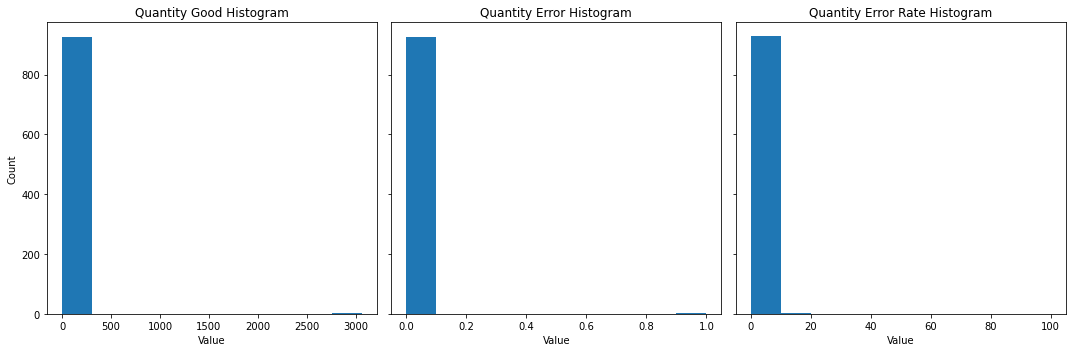

In [8]:
n_bins=10

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))
for i in range(3):
    axs[i].set_xlabel('Value')

axs[0].set_ylabel('Count')
axs[0].hist(df['QTYGOOD'], bins=n_bins)
axs[0].set_title('Quantity Good Histogram')
axs[1].hist(df['QTYERROR'], bins=n_bins)
axs[1].set_title('Quantity Error Histogram')
axs[2].hist(df['ERROR_RATE'], bins=n_bins)
axs[2].set_title('Quantity Error Rate Histogram')
plt.show()

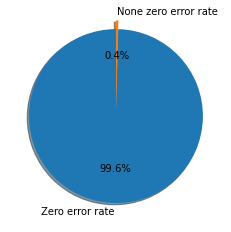

In [9]:
errorRateZero, errorRateNoneZero = 0, 0
for key, val in Counter(df['ERROR_RATE']).items():
    if key == 0:
        errorRateZero += val
    else:
        errorRateNoneZero += val

plt.pie([errorRateZero, errorRateNoneZero], labels=['Zero error rate', 'None zero error rate'], explode=[0,0.1], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

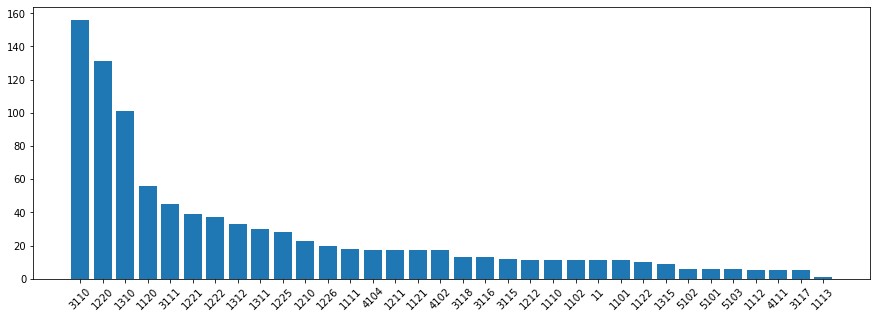

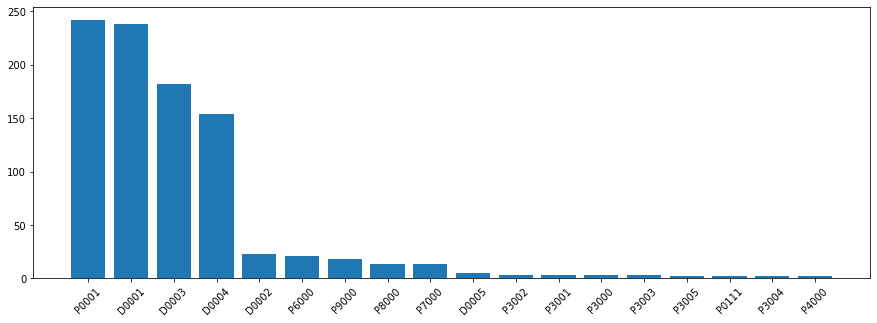

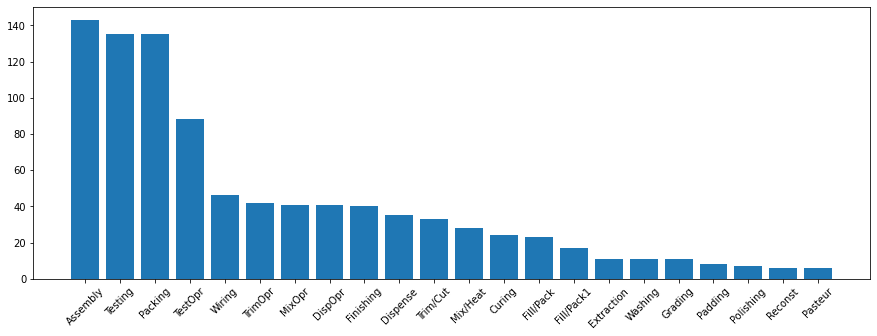

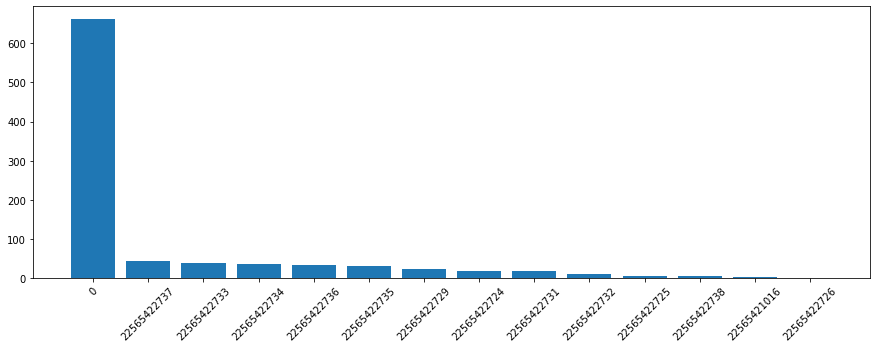

In [10]:
plotCategory(df, 'WrkCtrID')
plotCategory(df, 'ITEMID')
plotCategory(df, 'OprID')
plotCategory(df, 'WORKER')

# Preprocessing and feature engineering

In [11]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)
# X = data.to_numpy()
errorX = data.loc[:]
# y = df['ERROR_RATE'].astype(str)
data['ERROR_GROUP'] = np.where(df.ERROR_RATE > 0, True, False)
errorY = data['ERROR_GROUP'].astype(str)

In [12]:
errorSampleDict = getSampleDict(errorY)
maj = getMajorityClass(errorY)
classWeight = getClassWeight(errorY, maj)

In [13]:
pipeline = getResamplePipeline(errorSampleDict)
errorModel = RandomForestClassifier(random_state=42, class_weight=None)
errorX_res, errorY_res = pipeline.fit_resample(errorX, errorY)

# Training and validating

In [14]:
crossValidate(errorModel, errorX_res, errorY_res, 5, 3)

0.9917138805687405

In [15]:
errorX_train, errorX_test, errorY_train, errorY_test = train_test_split(errorX_res, errorY_res, random_state=0)
errorModel.fit(errorX_train, errorY_train)
print('Score for train data', errorModel.score(errorX_train, errorY_train))
print('Score for test data', errorModel.score(errorX_test, errorY_test))

Score for train data 0.9942363112391931
Score for test data 0.9870689655172413


# Feature Importance

/Users/Mr_ren/DTU/thesis/utils.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


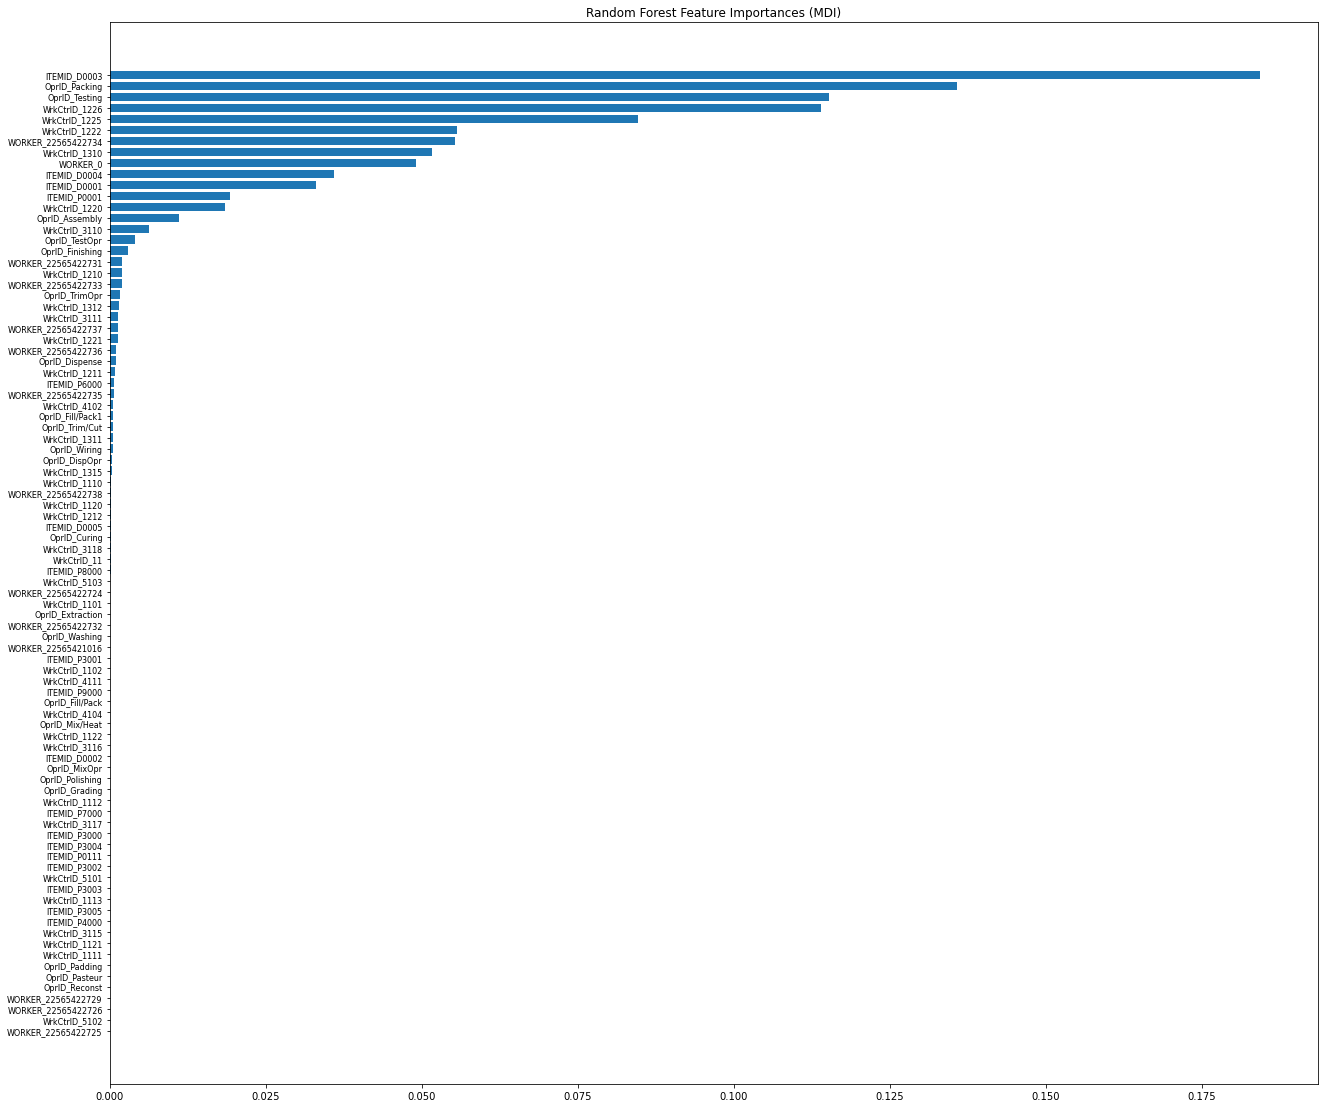

In [16]:
feature_names = pipeline.named_steps['encoding'].get_feature_names(list(errorX.columns))
randomForestFeatureImportancePlot(errorX_res, errorY_res, feature_names, errorModel)

## Permutation feature importance

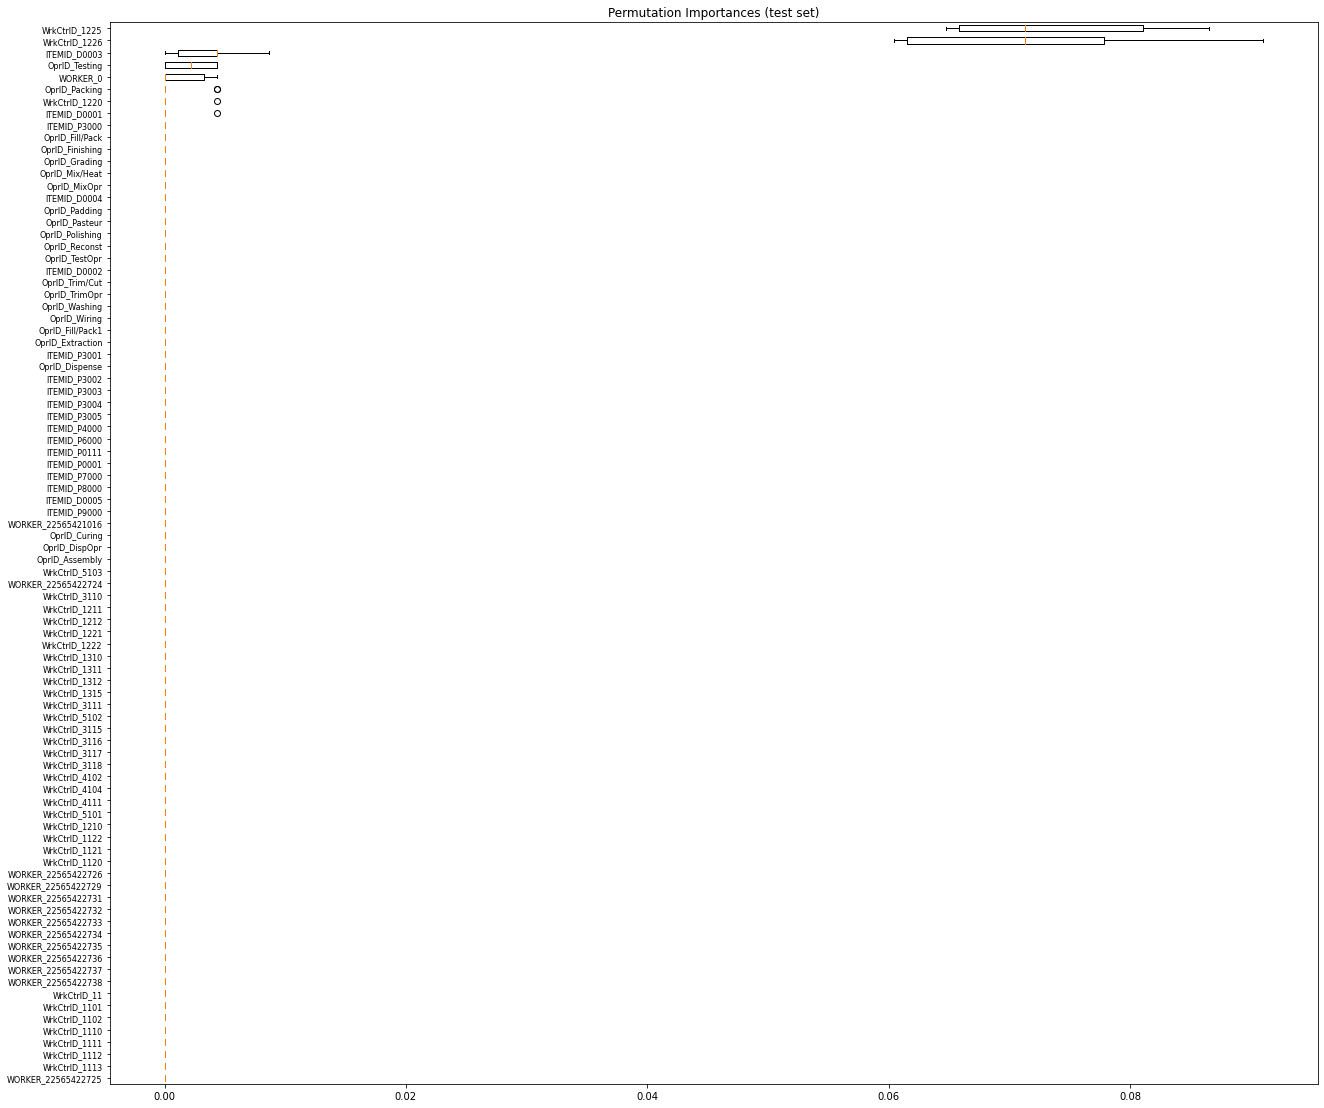

In [17]:
result = permuationFeatureImportancePlot(errorModel, errorX_test.todense(), errorY_test, feature_names)

## Multicollinear Features

In [18]:
# Select features that contribute to the model
sorted_idx = result.importances_mean.argsort()
errorX_res_df = pd.DataFrame(errorX_res.toarray(), columns=feature_names)
selected_features = feature_names[sorted_idx][-10:]
errorX_res_selected = errorX_res_df.loc[:, selected_features]

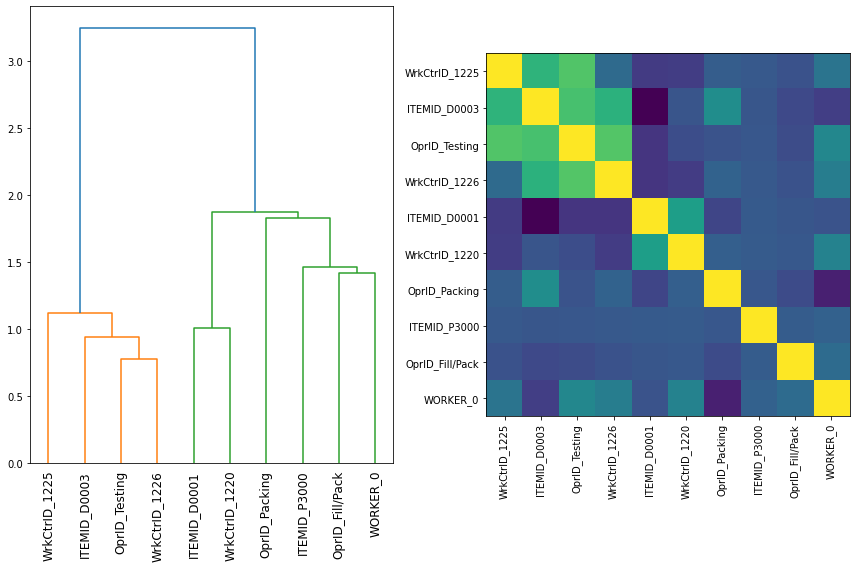

In [19]:
correlationPlot(errorX_res_selected, selected_features)

# Time Usage Deviation

In [20]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)

# timeY = clusterKDE(df['TIME_DEVIATION'])
# timeY = clusterDBSCAN(df['TIME_DEVIATION'])
targets = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=5).fit(targets)
timeY = kmeans.labels_

timeX = data.loc[:]

# Build Pipeline

In [90]:
maj = getMajorityClass(timeY)
classWeight = getClassWeight(timeY, maj, 2)
timeModel = svm.SVC(C=1000, kernel='linear', class_weight=classWeight)
# timeModel = RandomForestClassifier(random_state=42)
timeSampleDict = getSampleDict(timeY)
timePipeline = getResamplePipeline(timeSampleDict, k_neighbors=2)
timeX_res, timeY_res = timePipeline.fit_resample(timeX, timeY)

# Validating

In [91]:
crossValidate(timeModel, timeX_res, timeY_res, 4, 3, 'f1_macro')

0.9352626562901808

In [92]:
timeX_train, timeX_test, timeY_train, timeY_test = train_test_split(timeX_res, timeY_res, random_state=0)
timeModel.fit(timeX_train, timeY_train)
print('Score for train data', timeModel.score(timeX_train, timeY_train))
print('Score for test data', timeModel.score(timeX_test, timeY_test))

Score for train data 0.9451632778804683
Score for test data 0.9280442804428044


In [32]:
timeX_train, timeX_test, timeY_train, timeY_test = train_test_split(timeX_res, timeY_res, random_state=0)
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
clf = GridSearchCV(svm.SVC(class_weight=classWeight), tuned_parameters, scoring='f1_macro')
clf.fit(timeX_train, timeY_train)
    

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = timeY_test, clf.predict(timeX_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

0.664 (+/-0.022) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.067 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.834 (+/-0.016) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.664 (+/-0.022) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.902 (+/-0.036) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.834 (+/-0.016) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.916 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.902 (+/-0.036) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.913 (+/-0.020) for {'C': 1, 'kernel': 'linear'}
0.920 (+/-0.017) for {'C': 10, 'kernel': 'linear'}
0.921 (+/-0.018) for {'C': 100, 'kernel': 'linear'}
0.921 (+/-0.013) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision 

# Feature Importance

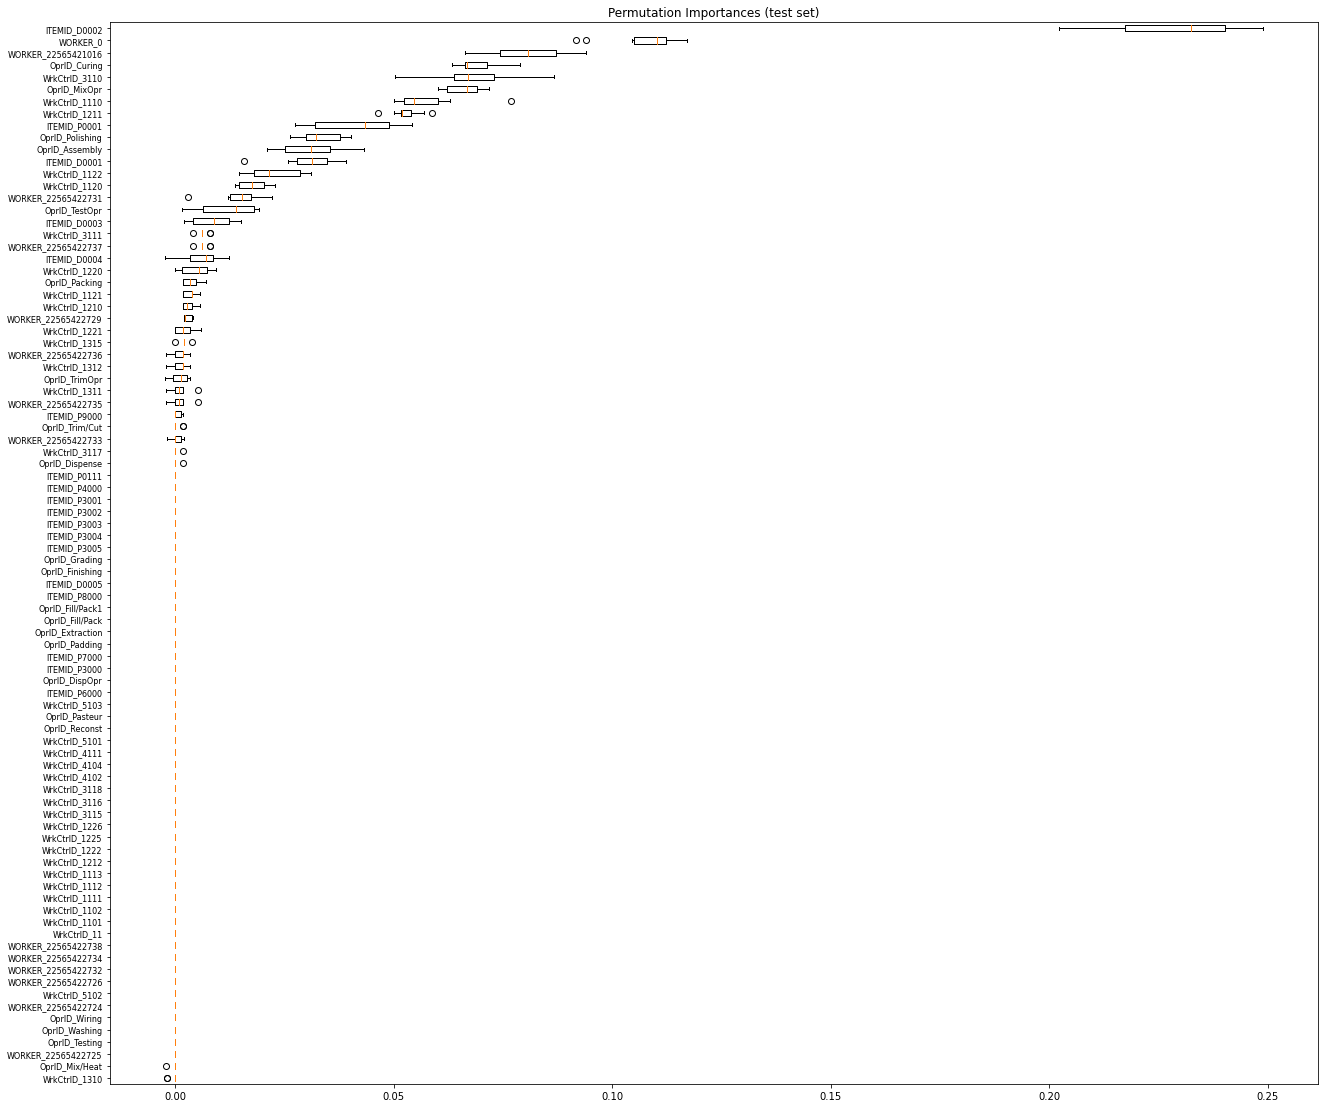

In [93]:
result = permuationFeatureImportancePlot(timeModel, timeX_test.todense(), timeY_test, feature_names)

# Feature Correlation 

In [94]:
sorted_idx = result.importances_mean.argsort()
timeX_res_df = pd.DataFrame(timeX_res.toarray(), columns=feature_names)
selected_features = feature_names[sorted_idx][-10:]
timeX_res_selected = timeX_res_df.loc[:, selected_features]

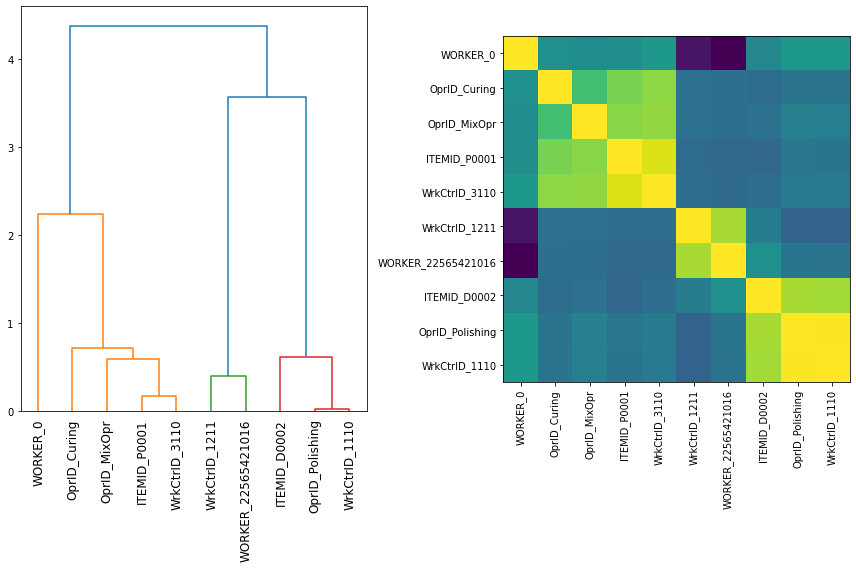

In [95]:
correlationPlot(timeX_res_selected, selected_features)

# Reselect Features

In [96]:
def removeFeatures(X, remove_features, feature_names):
    remove_index = []
    for feature in remove_features:
        remove_index.append(np.where(feature_names == feature)[0][0])

    remainX = np.delete(X.todense(), remove_index, 1)
    return remainX, np.array([name for name in feature_names if name not in remove_features])

In [97]:
remove_features = ["WrkCtrID_1110", "ITEMID_P0001"]
remainX, remain_names = removeFeatures(timeX_res, remove_features, feature_names)

In [98]:
timeX_train, timeX_test, timeY_train, timeY_test = train_test_split(remainX, timeY_res, random_state=0)
timeModel.fit(timeX_train, timeY_train)
print('Score for train data', timeModel.score(timeX_train, timeY_train))
print('Score for test data', timeModel.score(timeX_test, timeY_test))

Score for train data 0.9451632778804683
Score for test data 0.9243542435424354


In [99]:
crossValidate(timeModel, remainX, timeY_res, 4, 3, 'f1_macro')

0.9355790526121791

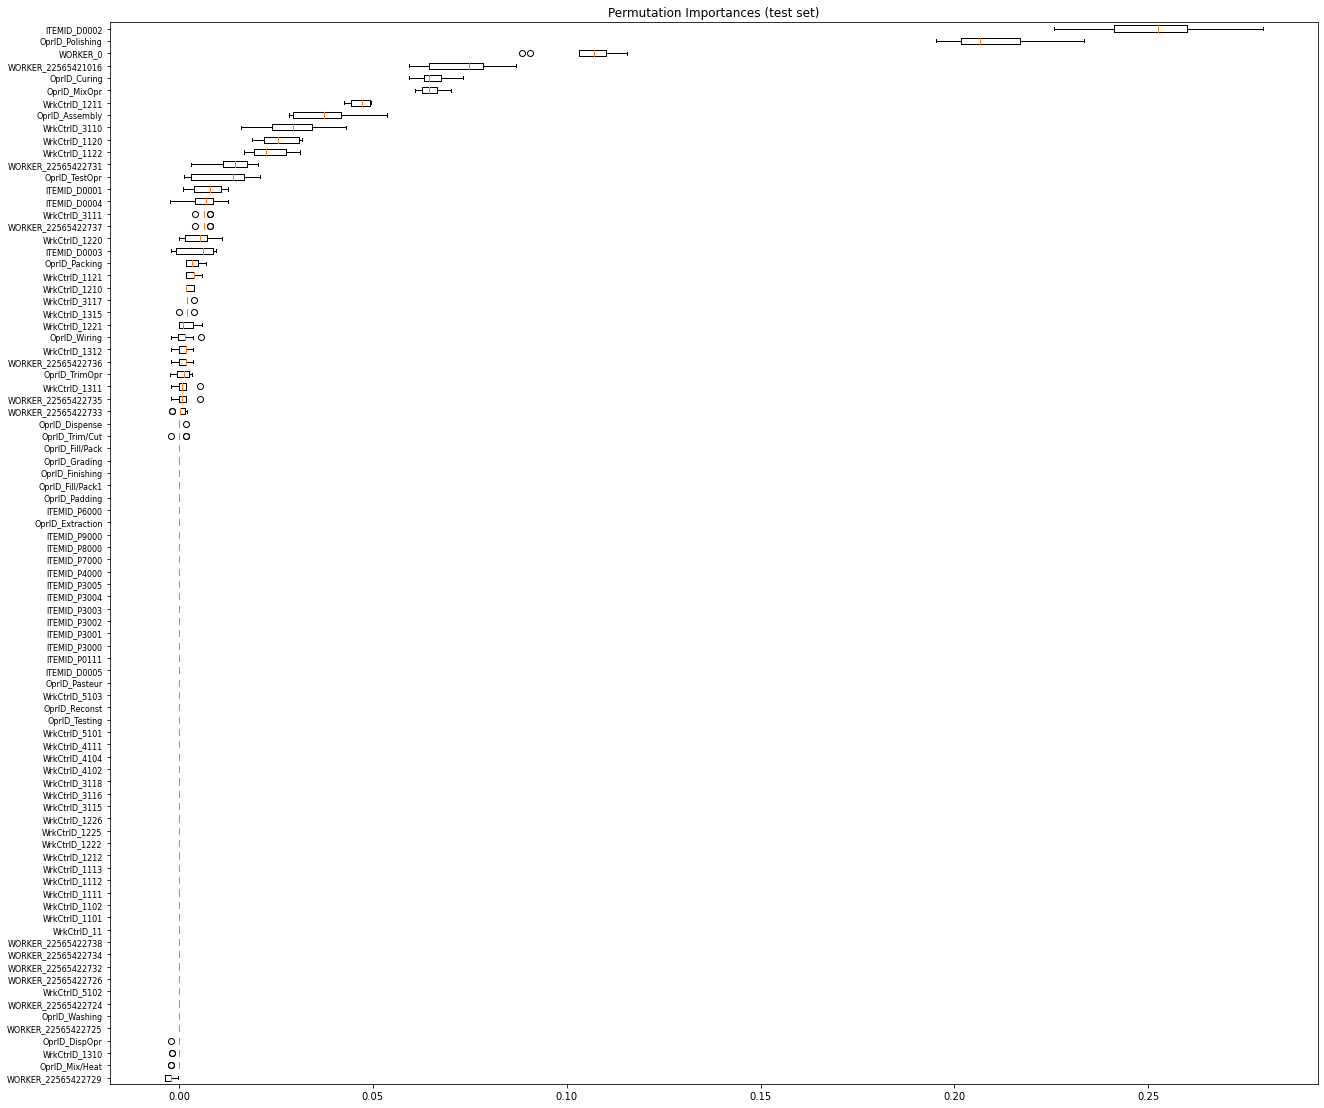

In [100]:
result = permuationFeatureImportancePlot(timeModel, timeX_test, timeY_test, remain_names)

# Review

In [110]:
df['cluster'] = timeY

In [126]:
# query = 'OprID == "Polishing" or ITEMID == "D0002"'
query = 'ITEMID == "P0001"'
df.query(query)

,Unnamed: 0,ProdId,ITEMID,OprID,WORKER,WrkCtrID,CalcHours,Amount,Hours,QTYERROR,QTYGOOD,TIME_DEVIATION,anomaly,TOTAL,ERROR_RATE,cluster
0,0,B000001,P0001,Curing,0,3110,38.97112,194.86,19.48556,0.0,2917.0,19.48556,1,2917.0,0.0,3
1,2,B000001,P0001,DispOpr,0,3110,29.22834,292.28,29.22834,0.0,0.0,0.00000,1,0.0,0.0,0
2,3,B000001,P0001,Trim/Cut,0,3110,19.48556,97.43,9.74278,0.0,2917.0,9.74278,1,2917.0,0.0,0
3,4,B000001,P0001,TrimOpr,0,3110,9.74278,97.43,9.74278,0.0,0.0,0.00000,1,0.0,0.0,0
4,5,B000002,P0001,Curing,0,3110,1.56312,7.82,0.78156,0.0,117.0,0.78156,1,117.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,401,B000046,P0001,MixOpr,0,3110,0.04008,0.40,0.04008,0.0,0.0,0.00000,1,0.0,0.0,0
320,403,B000046,P0001,TrimOpr,0,3110,0.00668,0.07,0.00668,0.0,0.0,0.00000,1,0.0,0.0,0
324,413,B000050,P0001,Curing,0,3110,122.76504,204.61,20.46084,0.0,3063.0,102.30420,1,3063.0,0.0,4
325,417,B000050,P0001,MixOpr,0,3110,184.14756,613.83,61.38252,0.0,0.0,122.76504,1,0.0,0.0,4


In [127]:
Counter(df.query(query).cluster)

Counter({3: 2, 0: 238, 4: 2})

In [128]:
Counter(df.cluster)

Counter({3: 42, 0: 866, 1: 11, 4: 6, 2: 6})

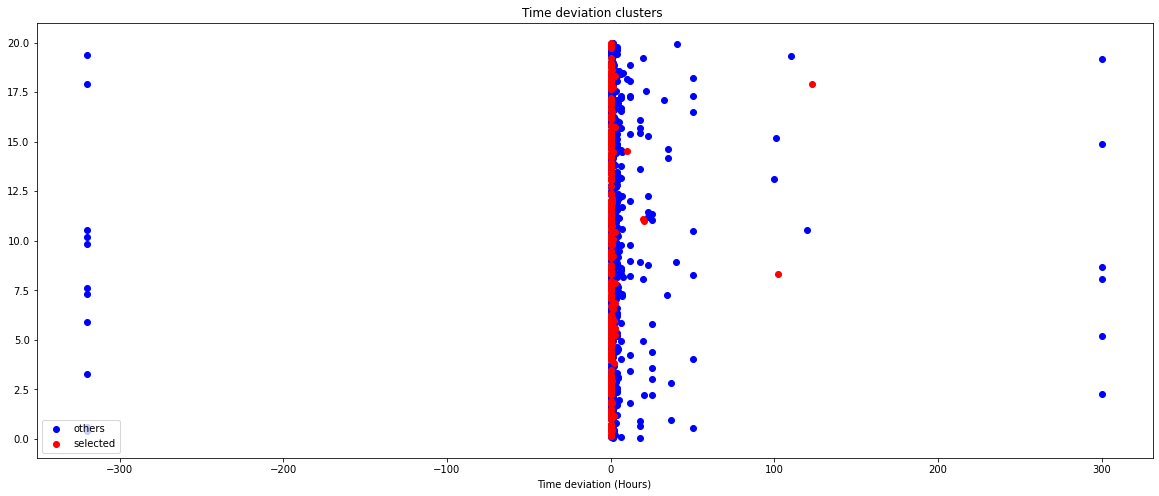

In [130]:
others = df[df.index.isin([i for i in df.index if i not in df.query(query).index])]
colors = ['blue', 'red']
labels = ['others', 'selected']
fig, ax = plt.subplots(figsize = (20, 8))
for i, cluster in enumerate([others, df.query(query)]):
    y = []
    for _ in range(len(cluster['TIME_DEVIATION'])):
        y.append(random.random() * 20)
    _ = ax.scatter(cluster['TIME_DEVIATION'], y, color=colors[i], label=labels[i])

ax.legend(loc="lower left")
ax.set_title('Time deviation clusters ')
ax.set_xlabel('Time deviation (Hours)')
plt.show()